In [1]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [103]:
# Reading transformed illinois dataset
illinois = pd.read_csv("illinois-transformed.csv")

In [104]:
# Reading transformed california dataset
cali = pd.read_csv("cali-transformed.csv")

In [105]:
illinois.head()

,ACTIVITY LEVEL,Total Number of Posts,Fear,Anger,Joy,Sadness,Surprise,Neutral,Disgust,No Emotion Attached,ACTIVITY LEVEL LABEL_Low,ACTIVITY LEVEL LABEL_Minimal,ACTIVITY LEVEL LABEL_Moderate
0,7,766,23,42,37,24,0,81,356,203,0,0,1
1,10,857,29,34,37,40,1,74,431,211,0,0,0
2,10,988,16,52,36,30,0,87,483,284,0,0,0
3,10,1144,36,62,48,47,0,151,621,179,0,0,0
4,10,940,24,57,37,30,0,86,531,175,0,0,0


In [106]:
cali.head()

,ACTIVITY LEVEL,Total Number of Posts,Fear,Anger,Joy,Sadness,Surprise,Neutral,Disgust,No Emotion Attached,ACTIVITY LEVEL LABEL_Low,ACTIVITY LEVEL LABEL_Minimal,ACTIVITY LEVEL LABEL_Moderate
0,10,3363,69,173,144,111,0,391,1459,1016,0,0,0
1,10,3573,84,202,134,111,1,326,1604,1111,0,0,0
2,10,3674,97,206,136,124,5,354,1675,1077,0,0,0
3,10,4636,152,247,204,155,5,652,2285,936,0,0,0
4,10,3990,103,210,183,153,4,486,2028,823,0,0,0


In [107]:
# Remove total number of posts (its derived from emotion number of posts)
# Remove Activity level labels 
# Remove week and month
columns = ['Total Number of Posts', 'ACTIVITY LEVEL LABEL_Low', 'ACTIVITY LEVEL LABEL_Minimal', 
           'ACTIVITY LEVEL LABEL_Moderate']
illinois = illinois.drop(columns, axis=1)
cali = cali.drop(columns, axis=1)

In [108]:
cali.head(2)

,ACTIVITY LEVEL,Fear,Anger,Joy,Sadness,Surprise,Neutral,Disgust,No Emotion Attached
0,10,69,173,144,111,0,391,1459,1016
1,10,84,202,134,111,1,326,1604,1111


In [109]:
illinois.head(2)

,ACTIVITY LEVEL,Fear,Anger,Joy,Sadness,Surprise,Neutral,Disgust,No Emotion Attached
0,7,23,42,37,24,0,81,356,203
1,10,29,34,37,40,1,74,431,211


## Modelling

First, I will try modelling illinois data using XGBoost and test it on a illinois data itself. Next I will try to model cali data and test on cali data. 

After above analysis, I will rescale the number of posts based on the population and model cali data and test it on illinois data using XGBoost (Rescaling part is not complete yet. I have built the model without rescaling for now|)

The metric for model evaluation is **area under the ROC curve** and **Accuracy**

### After this section, I have modelled our datasets using grouped Activity Levels 

Modelling Illinois data using XGBoost

In [110]:
# create x and y train
X = illinois.drop('ACTIVITY LEVEL', axis=1)
y = illinois[['ACTIVITY LEVEL']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(252, 8)
(252, 1)
(64, 8)
(64, 1)


In [111]:
# check the average activity level in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

ACTIVITY LEVEL    3.789683
dtype: float64
ACTIVITY LEVEL    3.71875
dtype: float64


In [112]:
num_of_classes = len(illinois['ACTIVITY LEVEL'].unique())

In [113]:
num_of_classes

10

In [114]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="auc", num_class=num_of_classes)

xgb.fit(X_train,y_train)

pred = xgb.predict(X_test)
val = xgb.predict(X_test)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
val_lb = lb.transform(val)

roc_auc_score(y_test_lb, val_lb, average='weighted')

0.5444834753833634

In [115]:
from sklearn.metrics import accuracy_score
# make predictions for test data
predictions = xgb.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 21.88%


In [116]:
output = pd.DataFrame()
output['Expected Output'] = y_test['ACTIVITY LEVEL']
output['Predicted Output'] = val
output

,Expected Output,Predicted Output
257,10,10
165,8,3
211,2,8
295,7,1
19,2,3
...,...,...
89,3,6
213,1,1
48,9,1
189,2,3


In [82]:
# Attempt at hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="auc", num_class=num_of_classes, max_depth=2, n_estimators=200,)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

In [ ]:
y_train1 = preprocessing.label_binarize(y, classes=[1,2,3,4,5,6,7,8,9,10])

In [46]:
# fit the model
y_train = preprocessing.label_binarize(y_train, classes=[1,2,3,4,5,6,7,8,9,10])

model_cv.fit(X_train, y_train)    

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.0s finished


ValueError: bad input shape (437, 10)

In [ ]:
# At this point I am unable to tune hyperparameters for multiclass classification using XGBoost
# Working on resolving this issue. 
# With the default XGBoost model the auc is 0.61 for illinois

### Note on feature importance :
Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance. This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

In [117]:
# feature importance
importance = dict(zip(X_train.columns, xgb.feature_importances_))
importance

{'Fear': 0.14165562,
 'Anger': 0.15462308,
 'Joy': 0.1255616,
 'Sadness': 0.10929249,
 'Surprise': 0.107986435,
 'Neutral': 0.098181814,
 'Disgust': 0.12483027,
 'No Emotion Attached': 0.13786866}

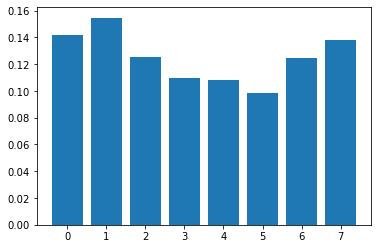

In [118]:
# plot
# numbers show corresponding features shown above
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [72]:
# Anger appears to be an important feature

### Modelling California data

In [119]:
# create x and y train
X = cali.drop('ACTIVITY LEVEL', axis=1)
y = cali[['ACTIVITY LEVEL']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(252, 8)
(252, 1)
(64, 8)
(64, 1)


In [120]:
# check the average activity level in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

ACTIVITY LEVEL    3.313492
dtype: float64
ACTIVITY LEVEL    3.359375
dtype: float64


In [121]:
num_of_classes = len(illinois['ACTIVITY LEVEL'].unique())

In [122]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

xgb_cali = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="auc", num_class=num_of_classes)

xgb_cali.fit(X_train,y_train)

pred = xgb_cali.predict(X_test)
val = xgb_cali.predict(X_test)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
val_lb = lb.transform(val)

roc_auc_score(y_test_lb, val_lb, average='weighted')

0.5924934505616638

In [123]:
from sklearn.metrics import accuracy_score
# make predictions for test data
predictions = xgb_cali.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 40.62%


In [124]:
output = pd.DataFrame()
output['Expected Output'] = y_test['ACTIVITY LEVEL']
output['Predicted Output'] = val
output

,Expected Output,Predicted Output
257,10,8
165,8,7
211,1,3
295,6,6
19,8,6
...,...,...
89,1,1
213,1,1
48,5,1
189,1,1


In [125]:
# feature importance
importance = dict(zip(X_train.columns, xgb_cali.feature_importances_))
importance

{'Fear': 0.13919398,
 'Anger': 0.14955768,
 'Joy': 0.11732257,
 'Sadness': 0.12668021,
 'Surprise': 0.10232481,
 'Neutral': 0.10202225,
 'Disgust': 0.14528447,
 'No Emotion Attached': 0.11761401}

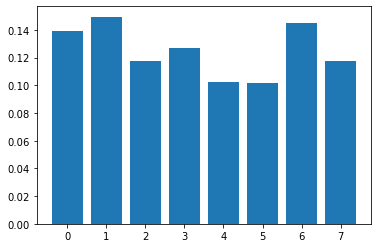

In [126]:
# plot
plt.bar(range(len(xgb_cali.feature_importances_)), xgb_cali.feature_importances_)
plt.show()

In [ ]:
# Anger appears to be an important feature followed by disgust

####  Modelling with cali data and testing on illinois data

In [127]:
# create x and y train
X_train = cali.drop('ACTIVITY LEVEL', axis=1)
y_train = cali[['ACTIVITY LEVEL']]
X_test = illinois.drop('ACTIVITY LEVEL', axis=1)
y_test = illinois[['ACTIVITY LEVEL']]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(316, 8)
(316, 1)
(316, 8)
(316, 1)


In [128]:
# check the average activity level in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

ACTIVITY LEVEL    3.322785
dtype: float64
ACTIVITY LEVEL    3.775316
dtype: float64


In [129]:
num_of_classes = len(illinois['ACTIVITY LEVEL'].unique())

In [130]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

model = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="auc", num_class=num_of_classes)

model.fit(X_train,y_train)

pred = model.predict(X_test)
val = model.predict(X_test)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
val_lb = lb.transform(val)

roc_auc_score(y_test_lb, val_lb, average='weighted')

0.49680747814774867

In [131]:
from sklearn.metrics import accuracy_score
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 15.19%


In [132]:
output = pd.DataFrame()
output['Expected Output'] = y_test['ACTIVITY LEVEL']
output['Predicted Output'] = val
output

,Expected Output,Predicted Output
0,7,6
1,10,6
2,10,6
3,10,4
4,10,6
...,...,...
311,5,2
312,5,2
313,7,2
314,9,2


In [133]:
# feature importance
importance = dict(zip(X_train.columns, xgb_cali.feature_importances_))
importance

{'Fear': 0.13919398,
 'Anger': 0.14955768,
 'Joy': 0.11732257,
 'Sadness': 0.12668021,
 'Surprise': 0.10232481,
 'Neutral': 0.10202225,
 'Disgust': 0.14528447,
 'No Emotion Attached': 0.11761401}

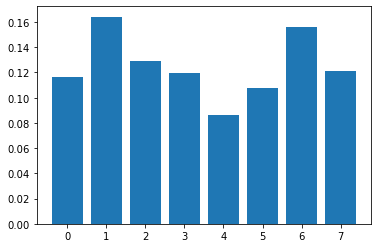

In [158]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

# Grouping based on activity level:  3 or higher is 1
### Modelling cali data after grouping activity level:

In [135]:
level_group_map = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6:1, 7:1, 8:1, 9:1, 10:1}
cali["level_group"] = cali["ACTIVITY LEVEL"].map(level_group_map).astype(float)

Text(0, 0.5, 'Count')

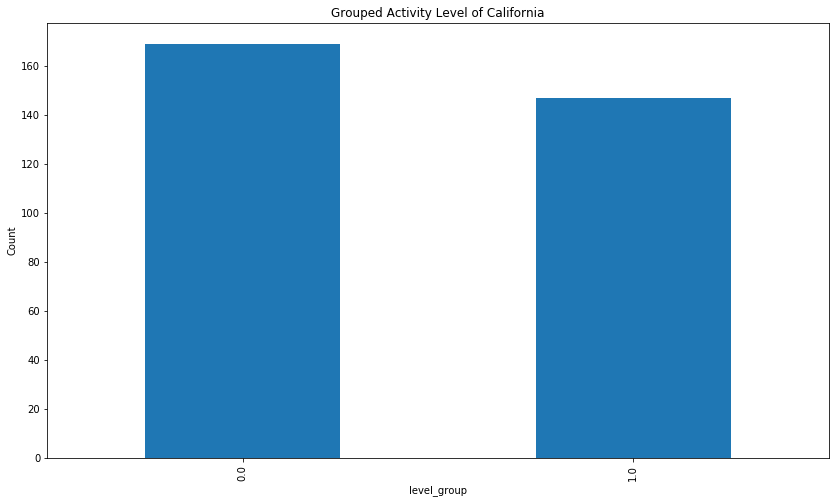

In [136]:
ax = cali['level_group'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Grouped Activity Level of California")
ax.set_xlabel("level_group")
ax.set_ylabel("Count")

In [137]:
cali=cali.drop("ACTIVITY LEVEL", axis = 1)

In [143]:
# create x and y train
X = cali.drop('level_group', axis=1)
y = cali[['level_group']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(252, 8)
(252, 1)
(64, 8)
(64, 1)


In [146]:

# a1 = XGBClassifier()
# a1.fit(X_train, y_train)
# print(a1)
# # make predictions for test data
# predictions = a1.predict(X_test)
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

a1 = XGBClassifier(booster='gbtree', random_state=42, eval_metric="auc")

a1.fit(X_train,y_train)

pred = a1.predict(X_test)
val = a1.predict(X_test)

# lb = preprocessing.LabelBinarizer()
# lb.fit(y_test)

# y_test_lb = lb.transform(y_test)
# val_lb = lb.transform(val)

roc_auc_score(y_test, val)

0.7672672672672673

In [147]:

# make predictions for test data
predictions = a1.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.56%


In [160]:
# feature importance
importance = dict(zip(X_train.columns, a1.feature_importances_))
importance

{'Fear': 0.15524463,
 'Anger': 0.24697809,
 'Joy': 0.088552386,
 'Sadness': 0.09622115,
 'Surprise': 0.06299323,
 'Neutral': 0.12949577,
 'Disgust': 0.1410813,
 'No Emotion Attached': 0.07943345}

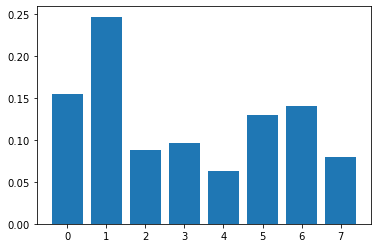

In [159]:
# plot
plt.bar(range(len(a1.feature_importances_)), a1.feature_importances_)
plt.show()

### Modelling Illinois data after grouping activity level

In [148]:
illinois["level_group"] = illinois["ACTIVITY LEVEL"].map(level_group_map).astype(float)

Text(0, 0.5, 'Count')

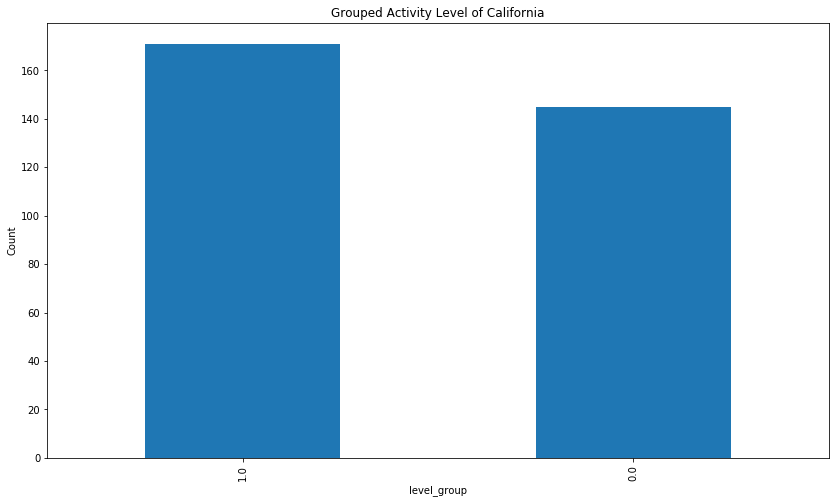

In [149]:
ax = illinois['level_group'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Grouped Activity Level of California")
ax.set_xlabel("level_group")
ax.set_ylabel("Count")

In [150]:
illinois=illinois.drop("ACTIVITY LEVEL", axis = 1)

In [151]:
# create x and y train
X = illinois.drop('level_group', axis=1)
y = illinois[['level_group']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(252, 8)
(252, 1)
(64, 8)
(64, 1)


In [152]:
a2 = XGBClassifier(booster='gbtree', random_state=42, eval_metric="auc")

a2.fit(X_train,y_train)

pred = a2.predict(X_test)
val = a2.predict(X_test)


roc_auc_score(y_test, val)

0.578125

In [153]:

# make predictions for test data
predictions = a2.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.81%


In [161]:
# feature importance
importance = dict(zip(X_train.columns, a2.feature_importances_))
importance

{'Fear': 0.157414,
 'Anger': 0.18331285,
 'Joy': 0.099125534,
 'Sadness': 0.11230616,
 'Surprise': 0.105600946,
 'Neutral': 0.12183712,
 'Disgust': 0.12574649,
 'No Emotion Attached': 0.09465687}

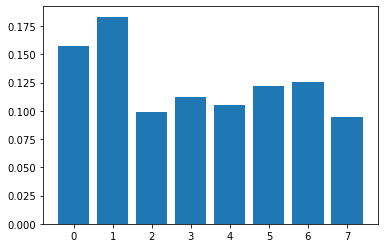

In [162]:
# plot
plt.bar(range(len(a2.feature_importances_)), a2.feature_importances_)
plt.show()

### Modelling cali data and testing on illinois after grouping activity levels

In [154]:
# create x and y train
X_train = cali.drop('level_group', axis=1)
y_train = cali[['level_group']]
X_test = illinois.drop('level_group', axis=1)
y_test = illinois[['level_group']]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(316, 8)
(316, 1)
(316, 8)
(316, 1)


In [155]:
# check the average activity level in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

level_group    0.46519
dtype: float64
level_group    0.541139
dtype: float64


In [156]:
a3 = XGBClassifier(booster='gbtree', random_state=42, eval_metric="auc")

a3.fit(X_train,y_train)

pred = a3.predict(X_test)
val = a3.predict(X_test)


roc_auc_score(y_test, val)

0.5332930026214964

In [157]:

# make predictions for test data
predictions = a3.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.00%


In [163]:
# feature importance
importance = dict(zip(X_train.columns, a3.feature_importances_))
importance

{'Fear': 0.12510574,
 'Anger': 0.26193807,
 'Joy': 0.11025572,
 'Sadness': 0.104759365,
 'Surprise': 0.06797269,
 'Neutral': 0.0992829,
 'Disgust': 0.13819452,
 'No Emotion Attached': 0.09249104}

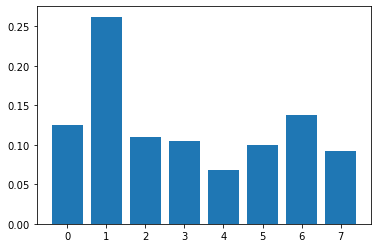

In [164]:
# plot
plt.bar(range(len(a3.feature_importances_)), a3.feature_importances_)
plt.show()